In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [40]:
import os
path2train="/kaggle/input/fetal-head-ultrasound-segmentation/Fetal_Head_Ultrasound/training"

imgsList = [pp for pp in os.listdir(path2train) if "Annotation" not in pp and (pp.endswith(".jpg") or pp.endswith(".png"))]
anntsList=[pp for pp in os.listdir(path2train) if "Annotation" in pp]
print("number of images:", len(imgsList))
print("number of annotations:", len(anntsList))

number of images: 800
number of annotations: 800


In [41]:
import numpy as np
np.random.seed(2019)
rndImgs=np.random.choice(imgsList,4)
rndImgs

array(['900_HC.png', '43_2HC.png', '594_HC.png', '971_4HC.png'],
      dtype='<U11')

In [42]:
import matplotlib.pylab as plt
from PIL import Image
from scipy import ndimage as ndi
from skimage.segmentation import mark_boundaries
from torchvision.transforms.functional import to_tensor, to_pil_image
import torch

def show_img_mask(img, mask):
    if torch.is_tensor(img):
        img=to_pil_image(img)
        mask=to_pil_image(mask)
        
        
    img_mask=mark_boundaries(np.array(img), 
                        np.array(mask),
                        outline_color=(0,1,0),
                        color=(0,1,0))
    plt.imshow(img_mask)

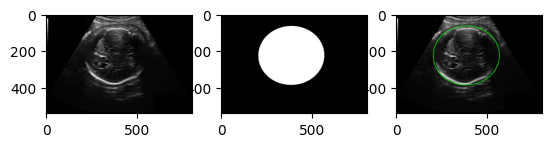

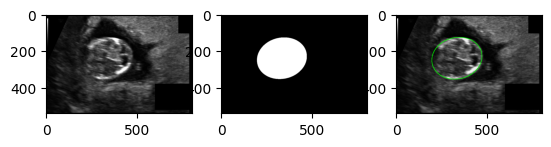

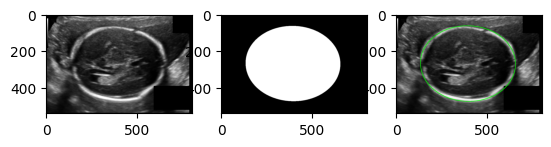

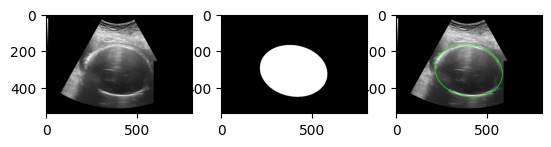

In [43]:
for fn in rndImgs:
    path2img = os.path.join(path2train, fn)
    path2annt= path2img.replace(".png", "_Annotation.png")
    img = Image.open(path2img)
    annt_edges = Image.open(path2annt)
    mask = ndi.binary_fill_holes(annt_edges)        

    plt.figure()
    plt.subplot(1, 3, 1) 
    plt.imshow(img, cmap="gray")

    plt.subplot(1, 3, 2) 
    plt.imshow(mask, cmap="gray")

    plt.subplot(1, 3, 3) 
    show_img_mask(img, mask)

(-0.5, 799.5, 539.5, -0.5)

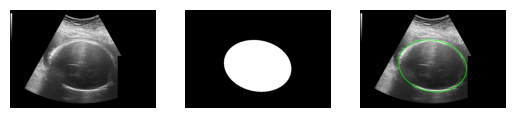

In [44]:
plt.figure()
plt.subplot(1, 3, 1) 
plt.imshow(img, cmap="gray")
plt.axis('off')

plt.subplot(1, 3, 2) 
plt.imshow(mask, cmap="gray")
plt.axis('off')    

plt.subplot(1, 3, 3) 
show_img_mask(img, mask)
plt.axis('off')

In [45]:
from albumentations import (
    HorizontalFlip,
    VerticalFlip,    
    Compose,
    Resize,
)

h,w=128,192
transform_train = Compose([ Resize(h,w), 
                HorizontalFlip(p=0.5), 
                VerticalFlip(p=0.5), 
              ])


transform_val = Resize(h,w)

In [46]:
from torch.utils.data import Dataset
from PIL import Image

In [47]:
from torchvision.transforms.functional import to_tensor, to_pil_image

class fetal_dataset(Dataset):
    def __init__(self, path2data, transform=None):      

        imgsList = [pp for pp in os.listdir(path2data) if "Annotation" not in pp and (pp.endswith(".jpg") or pp.endswith(".png"))]
        anntsList=[pp for pp in os.listdir(path2train) if "Annotation" in pp]

        self.path2imgs = [os.path.join(path2data, fn) for fn in imgsList] 
        self.path2annts= [p2i.replace(".png", "_Annotation.png") for p2i in self.path2imgs]

        self.transform = transform
    
    def __len__(self):
        return len(self.path2imgs)
      
    def __getitem__(self, idx):
        path2img = self.path2imgs[idx]
        image = Image.open(path2img)

        path2annt = self.path2annts[idx]
        annt_edges = Image.open(path2annt)
        mask = ndi.binary_fill_holes(annt_edges)        
        
        image= np.array(image)
        mask=mask.astype("uint8")        

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']            

        image= to_tensor(image)            
        mask=255*to_tensor(mask)            
        return image, mask

In [48]:
fetal_ds1=fetal_dataset(path2train, transform=transform_train)
fetal_ds2=fetal_dataset(path2train, transform=transform_val)
print(len(fetal_ds1))
print(len(fetal_ds2))

800
800


In [49]:
img,mask=fetal_ds1[0]
print(img.shape, img.type(),torch.max(img))
print(mask.shape, mask.type(),torch.max(mask))

torch.Size([1, 128, 192]) torch.FloatTensor tensor(0.9529)
torch.Size([1, 128, 192]) torch.FloatTensor tensor(1.)


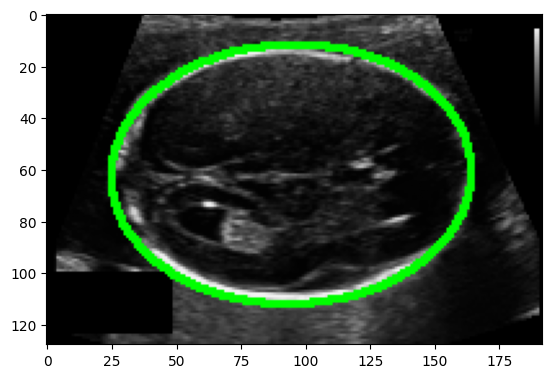

In [50]:
show_img_mask(img, mask)

In [51]:
from sklearn.model_selection import ShuffleSplit

sss = ShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

indices=range(len(fetal_ds1))

for train_index, val_index in sss.split(indices):
    print(len(train_index))
    print("-"*10)
    print(len(val_index))

640
----------
160


In [52]:
from torch.utils.data import Subset

train_ds=Subset(fetal_ds1,train_index)
print(len(train_ds))

val_ds=Subset(fetal_ds2,val_index)
print(len(val_ds))


640
160


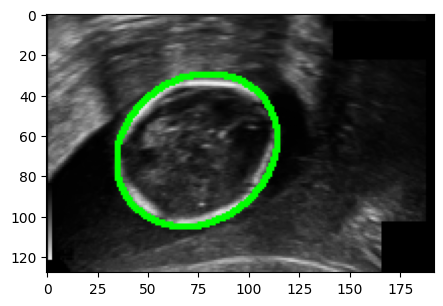

In [53]:
plt.figure(figsize=(5,5))
for img,mask in train_ds:
    show_img_mask(img,mask)
    break

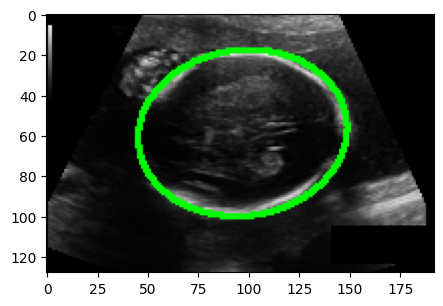

In [54]:
plt.figure(figsize=(5,5))
for img,mask in val_ds:
    show_img_mask(img,mask)
    break

In [55]:
from torch.utils.data import DataLoader
train_dl = DataLoader(train_ds, batch_size=4, shuffle=True, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=8, shuffle=False, pin_memory=True) 

In [56]:
for img_b, mask_b in train_dl:
    print(img_b.shape,img_b.dtype)
    print(mask_b.shape, mask_b.dtype)
    break

torch.Size([4, 1, 128, 192]) torch.float32
torch.Size([4, 1, 128, 192]) torch.float32


In [57]:
for img_b, mask_b in val_dl:
    print(img_b.shape,img_b.dtype)
    print(mask_b.shape, mask_b.dtype)
    break

torch.Size([8, 1, 128, 192]) torch.float32
torch.Size([8, 1, 128, 192]) torch.float32


In [58]:
torch.max(img_b)

tensor(0.9529)

In [59]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# ---------------------------
# Attention Block Definition
# ---------------------------
class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

# ---------------------------
# Double Convolution Block
# ---------------------------
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

# ---------------------------
# Attention U-Net Architecture
# ---------------------------
class AttentionUNet(nn.Module):
    def __init__(self, img_ch=1, output_ch=1):
        super(AttentionUNet, self).__init__()

        # Encoder
        self.conv1 = ConvBlock(img_ch, 64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = ConvBlock(64, 128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = ConvBlock(128, 256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = ConvBlock(256, 512)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bridge
        self.conv5 = ConvBlock(512, 1024)

        # Attention Blocks
        self.att4 = AttentionBlock(F_g=512, F_l=512, F_int=256)
        self.att3 = AttentionBlock(F_g=256, F_l=256, F_int=128)
        self.att2 = AttentionBlock(F_g=128, F_l=128, F_int=64)
        self.att1 = AttentionBlock(F_g=64, F_l=64, F_int=32)

        # Up-sampling + Conv
        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.up_conv4 = ConvBlock(1024, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up_conv3 = ConvBlock(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up_conv2 = ConvBlock(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.up_conv1 = ConvBlock(128, 64)

        # Output layer
        self.final_conv = nn.Conv2d(64, output_ch, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        # Encoder path
        e1 = self.conv1(x)
        p1 = self.pool1(e1)

        e2 = self.conv2(p1)
        p2 = self.pool2(e2)

        e3 = self.conv3(p2)
        p3 = self.pool3(e3)

        e4 = self.conv4(p3)
        p4 = self.pool4(e4)

        # Bridge
        b = self.conv5(p4)

        # Decoder path with Attention
        d4 = self.up4(b)
        e4 = self.att4(d4, e4)
        d4 = self.up_conv4(torch.cat([e4, d4], dim=1))

        d3 = self.up3(d4)
        e3 = self.att3(d3, e3)
        d3 = self.up_conv3(torch.cat([e3, d3], dim=1))

        d2 = self.up2(d3)
        e2 = self.att2(d2, e2)
        d2 = self.up_conv2(torch.cat([e2, d2], dim=1))

        d1 = self.up1(d2)
        e1 = self.att1(d1, e1)
        d1 = self.up_conv1(torch.cat([e1, d1], dim=1))

        out = self.final_conv(d1)
        return out


In [61]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [62]:
params_model = {
    "img_ch": 1,         # number of input channels
    "output_ch": 1,      # number of output classes/channels
}

model = AttentionUNet(**params_model).to(device)


In [63]:
print(model)

AttentionUNet(
  (conv1): ConvBlock(
    (conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): ConvBlock(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
 

In [64]:
from torchsummary import summary
summary(model, input_size=(1, h, w))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 192]             640
       BatchNorm2d-2         [-1, 64, 128, 192]             128
              ReLU-3         [-1, 64, 128, 192]               0
            Conv2d-4         [-1, 64, 128, 192]          36,928
       BatchNorm2d-5         [-1, 64, 128, 192]             128
              ReLU-6         [-1, 64, 128, 192]               0
         ConvBlock-7         [-1, 64, 128, 192]               0
         MaxPool2d-8           [-1, 64, 64, 96]               0
            Conv2d-9          [-1, 128, 64, 96]          73,856
      BatchNorm2d-10          [-1, 128, 64, 96]             256
             ReLU-11          [-1, 128, 64, 96]               0
           Conv2d-12          [-1, 128, 64, 96]         147,584
      BatchNorm2d-13          [-1, 128, 64, 96]             256
             ReLU-14          [-1, 128,

In [65]:
def dice_loss(pred, target, smooth = 1e-5):

    intersection = (pred * target).sum(dim=(2,3))
    union= pred.sum(dim=(2,3)) + target.sum(dim=(2,3)) 
    
    dice= 2.0 * (intersection + smooth) / (union+ smooth)    
    loss = 1.0 - dice
    
    return loss.sum(), dice.sum()

In [66]:
import torch.nn.functional as F

def loss_func(pred, target):
    bce = F.binary_cross_entropy_with_logits(pred, target,  reduction='sum')
    
    pred= torch.sigmoid(pred)
    dlv, _ = dice_loss(pred, target)
    
    loss = bce  + dlv

    return loss

In [67]:
for img_v,mask_v in val_dl:
    mask_v= mask_v[8:]
    break

for img_t,mask_t in train_dl:
    break
    


print(dice_loss(mask_v,mask_v))
loss_func(mask_v,torch.zeros_like(mask_v))

(tensor(0.), tensor(0.))


tensor(0.)

In [68]:
import torchvision

def metrics_batch(pred, target):
    pred= torch.sigmoid(pred)
    _, metric=dice_loss(pred, target)
    
    return metric

In [69]:
def loss_batch(loss_func, output, target, opt=None):   
    loss = loss_func(output, target)
    
    with torch.no_grad():
        pred= torch.sigmoid(output)
        _, metric_b=dice_loss(pred, target)
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

In [70]:
from torch import optim
opt = optim.Adam(model.parameters(), lr=3e-4)

In [71]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

In [72]:
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

current_lr=get_lr(opt)
print('current lr={}'.format(current_lr))

current lr=0.0003


In [73]:
def loss_epoch(model,loss_func,dataset_dl,sanity_check=False,opt=None):
    running_loss=0.0
    running_metric=0.0
    len_data=len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb=xb.to(device)
        yb=yb.to(device)
        
        output=model(xb)
        loss_b, metric_b=loss_batch(loss_func, output, yb, opt)
        running_loss += loss_b
        
        if metric_b is not None:
            running_metric+=metric_b

        if sanity_check is True:
            break
    
    loss=running_loss/float(len_data)
    
    metric=running_metric/float(len_data)
    
    return loss, metric

In [74]:
import copy
import time
def train_val(model, params):
    num_epochs=params["num_epochs"]
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]
    
    loss_history={
        "train": [],
        "val": []}
    
    metric_history={
        "train": [],
        "val": []}    
    
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss=float('inf')    
    
    for epoch in range(num_epochs):
        current_lr=get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr))   
        
        start_time = time.time()
        
        model.train()
        train_loss, train_metric=loss_epoch(model,loss_func,train_dl,sanity_check,opt)

        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        
        model.eval()
        with torch.no_grad():
            val_loss, val_metric=loss_epoch(model,loss_func,val_dl,sanity_check)
       
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)   
        
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
            torch.save(model.state_dict(), path2weights)
            print("Copied best model weights!")
            
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print("Loading best model weights!")
            model.load_state_dict(best_model_wts) 
            
        epoch_time = time.time() - start_time
        print("train loss: %.6f, dice: %.2f" %(train_loss,100*train_metric))
        print("val loss: %.6f, dice: %.2f" %(val_loss,100*val_metric))
        print("Epoch Time: %.2f seconds".format(epoch_time))
        print("-"*10) 
        

    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history        

In [75]:
opt = optim.Adam(model.parameters(), lr=3e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

path2models= "./models/"
if not os.path.exists(path2models):
        os.mkdir(path2models)

params_train={
    "num_epochs": 100,
    "optimizer": opt,
    "loss_func": loss_func,
    "train_dl": train_dl,
    "val_dl": val_dl,
    "sanity_check": False,
    "lr_scheduler": lr_scheduler,
    "path2weights": path2models+"weights.pt",
}

model,loss_hist,metric_hist=train_val(model,params_train)

Epoch 0/99, current lr=0.0003
Copied best model weights!
train loss: 5210.015820, dice: 73.22
val loss: 3726.544324, dice: 82.19
Epoch Time: %.2f seconds
----------
Epoch 1/99, current lr=0.0003
Copied best model weights!
train loss: 2694.902013, dice: 84.80
val loss: 2093.491785, dice: 87.37
Epoch Time: %.2f seconds
----------
Epoch 2/99, current lr=0.0003
train loss: 2172.964272, dice: 88.12
val loss: 3005.439673, dice: 86.22
Epoch Time: %.2f seconds
----------
Epoch 3/99, current lr=0.0003
Copied best model weights!
train loss: 1858.802972, dice: 90.21
val loss: 1480.130389, dice: 91.39
Epoch Time: %.2f seconds
----------
Epoch 4/99, current lr=0.0003
train loss: 1650.112106, dice: 91.44
val loss: 1732.238885, dice: 90.10
Epoch Time: %.2f seconds
----------
Epoch 5/99, current lr=0.0003
Copied best model weights!
train loss: 1555.470884, dice: 91.83
val loss: 1434.381647, dice: 91.82
Epoch Time: %.2f seconds
----------
Epoch 6/99, current lr=0.0003
train loss: 1506.648454, dice: 92.

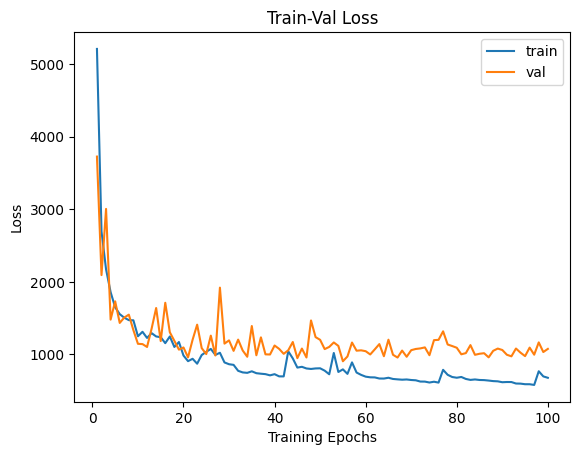

In [76]:
num_epochs=params_train["num_epochs"]

plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

In [77]:
import os
path2test="/kaggle/input/fetal-head-ultrasound-segmentation/Fetal_Head_Ultrasound/test"
imgsList=[pp for pp in os.listdir(path2test) if "Annotation" not in pp and (pp.endswith(".jpg") or pp.endswith(".png"))]
print("number of images:", len(imgsList))

number of images: 199


In [78]:
import numpy as np
np.random.seed(2019)
rndImgs=np.random.choice(imgsList,4)
rndImgs

array(['516_HC.png', '731_HC.png', '702_HC.png', '928_HC.png'],
      dtype='<U11')

In [79]:
path2weights="/kaggle/working/models/weights.pt"
model.load_state_dict(torch.load(path2weights))
model.eval()

/tmp/ipykernel_31/27485875.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path2weights))


AttentionUNet(
  (conv1): ConvBlock(
    (conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): ConvBlock(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
 

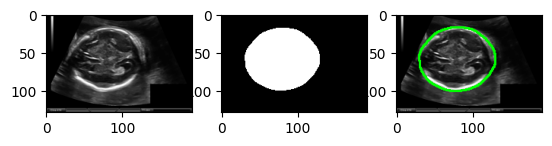

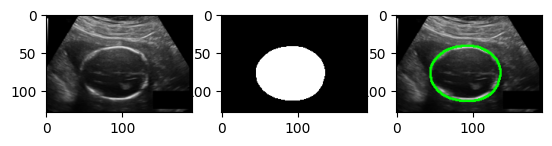

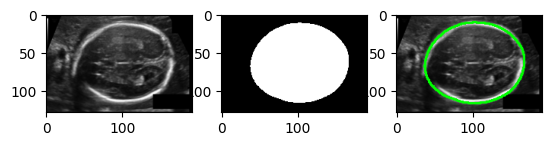

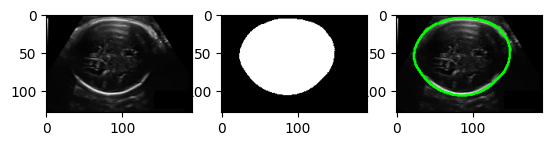

In [ ]:
from torchvision.transforms.functional import to_tensor, to_pil_image

for fn in rndImgs:
    path2img = os.path.join(path2test, fn)
    img = Image.open(path2img)
    img=img.resize((w,h))
    img_t=to_tensor(img).unsqueeze(0).to(device)
    
    #model(img_test.unsqueeze(0).cuda()).cpu()
    
    pred = model(img_t).cpu()

    pred=torch.sigmoid(pred)[0]
    mask_pred= (pred[0]>=0.5)

    plt.figure()
    plt.subplot(1, 3, 1) 
    plt.imshow(img, cmap="gray")

    plt.subplot(1, 3, 2) 
    plt.imshow(mask_pred, cmap="gray")
    
    plt.subplot(1, 3, 3) 
    show_img_mask(img, mask_pred)

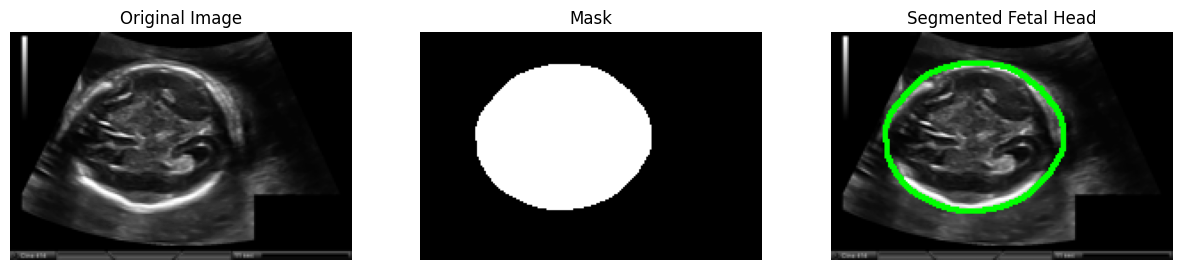

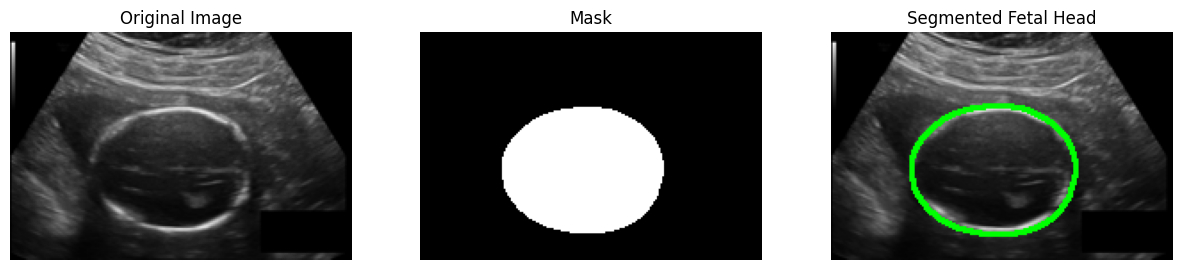

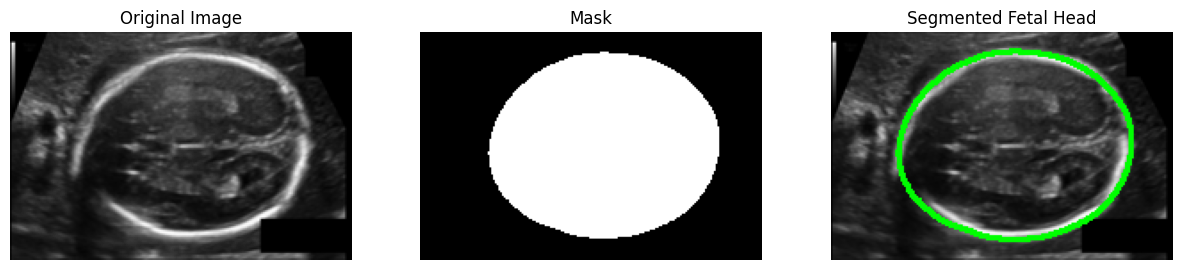

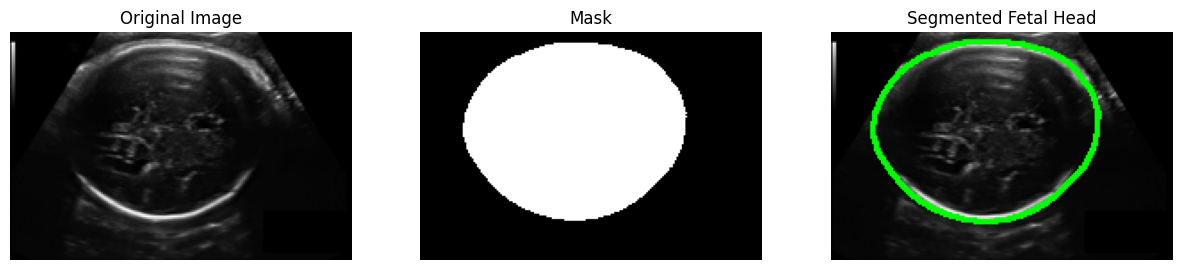

In [81]:
import skimage.filters
import skimage.measure

for fn in rndImgs:
    path2img = os.path.join(path2test, fn)
    img = Image.open(path2img)
    img = img.resize((w, h))
    img_t = to_tensor(img).unsqueeze(0).to(device)

    pred = model(img_t).cpu()
    pred = torch.sigmoid(pred)[0]
    mask_pred = (pred[0] >= 0.5)
    
    image_gray = mask_pred.numpy().astype('uint8') * 255  # Convert the mask to grayscale

    thresh = skimage.filters.threshold_otsu(image_gray)
    tumor_mask = image_gray > thresh
    
    pixel_size = 0.1  # the size of a pixel in millimeters
    label_image = skimage.measure.label(tumor_mask)
    region_props = skimage.measure.regionprops(label_image)
    
    if len(region_props) == 0:
        tumor_size_mm = 0.0
    else:
        tumor_area = region_props[0].area
        tumor_size_mm = tumor_area * pixel_size ** 2

    plt.figure(figsize=(15, 5))  # Set the figure size to (15, 5)

    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(img, cmap="gray")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Mask")
    # plt.title(f"Tumor size: {tumor_size_mm:.2f} mm^2", fontsize=14)  # Display the tumor size on the plot
    plt.imshow(mask_pred, cmap="gray")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Segmented Fetal Head")
    show_img_mask(img, mask_pred)
    plt.axis('off')

    plt.show()


In [82]:
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import jaccard_score
from scipy.spatial.distance import directed_hausdorff
from sklearn.metrics import mean_absolute_error

def dice_coeff(pred, target):
    pred = pred.astype(bool)
    target = target.astype(bool)
    intersection = (pred & target).sum()
    return 2. * intersection / (pred.sum() + target.sum() + 1e-5)

def iou_score(pred, target):
    pred = pred.astype(bool)
    target = target.astype(bool)
    intersection = (pred & target).sum()
    union = (pred | target).sum()
    return intersection / (union + 1e-5)

def hausdorff(pred, target):
    pred_pts = np.argwhere(pred)
    target_pts = np.argwhere(target)
    if pred_pts.size == 0 or target_pts.size == 0:
        return np.nan
    return max(directed_hausdorff(pred_pts, target_pts)[0], directed_hausdorff(target_pts, pred_pts)[0])

# Adjust paths to actual test mask directory if available
test_path = "/kaggle/input/fetal-head-ultrasound-segmentation/Fetal_Head_Ultrasound/test"
annot_suffix = "_Annotation.png"

dice_scores, iou_scores, hausdorff_dists, ssim_scores, mae_scores = [], [], [], [], []

for fn in imgsList:
    img_path = os.path.join(test_path, fn)
    mask_path = img_path.replace(".png", annot_suffix)  # assumes ground truth mask exists
    if not os.path.exists(mask_path):
        continue

    # Load and resize
    img = Image.open(img_path).resize((w, h))
    gt_mask = Image.open(mask_path).resize((w, h))
    gt_mask = np.array(ndi.binary_fill_holes(gt_mask)).astype(np.uint8)

    img_t = to_tensor(img).unsqueeze(0).to(device)
    pred = model(img_t).cpu()
    pred = torch.sigmoid(pred)[0]
    pred_mask = (pred[0] >= 0.5).numpy().astype(np.uint8)

    # Compute metrics
    dice_scores.append(dice_coeff(pred_mask, gt_mask))
    iou_scores.append(iou_score(pred_mask, gt_mask))
    hausdorff_dists.append(hausdorff(pred_mask, gt_mask))
    ssim_scores.append(ssim(gt_mask, pred_mask, data_range=1.0))
    mae_scores.append(mean_absolute_error(gt_mask.flatten(), pred_mask.flatten()))

# Display average metrics
print(f"Dice Coefficient: {np.mean(dice_scores):.4f}")
print(f"IoU: {np.mean(iou_scores):.4f}")
print(f"Hausdorff Distance: {np.nanmean(hausdorff_dists):.4f}")
print(f"SSIM: {np.mean(ssim_scores):.4f}")
print(f"MAE: {np.mean(mae_scores):.4f}")


Dice Coefficient: 0.9705
IoU: 0.9431
Hausdorff Distance: 4.3188
SSIM: 0.9264
MAE: 3.4902


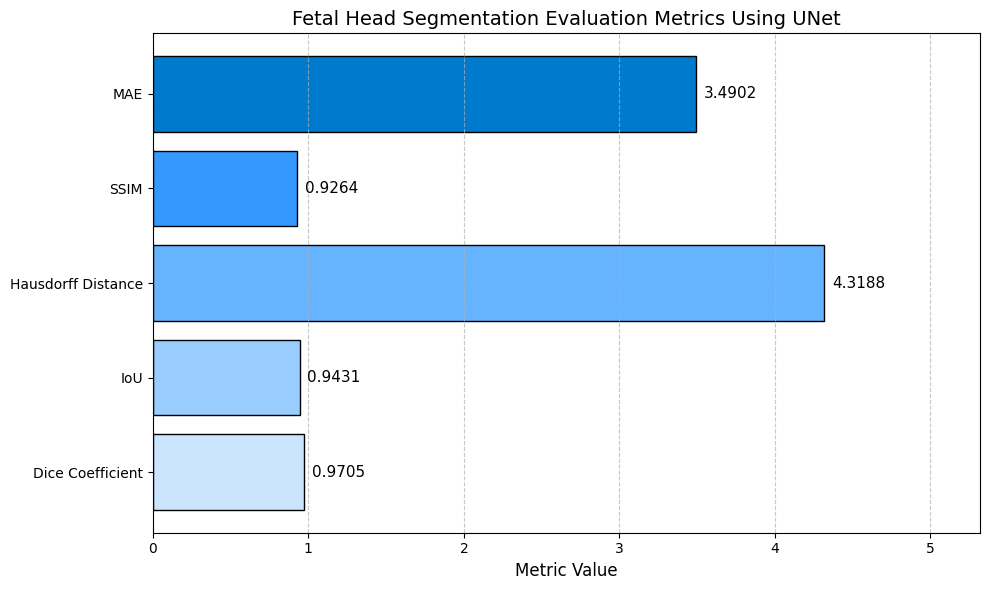

In [83]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics and values
metrics = ['Dice Coefficient', 'IoU', 'Hausdorff Distance', 'SSIM', 'MAE']
values = [0.9705, 0.9431,  4.3188, 0.9264, 3.4902]

# Create shades of blue
colors = ['#cce5ff', '#99ccff', '#66b3ff', '#3399ff', '#007acc']

# Set up the plot
plt.figure(figsize=(10, 6))
bars = plt.barh(metrics, values, color=colors, edgecolor='black')

# Add metric values next to the bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.05, bar.get_y() + bar.get_height()/2,
             f'{width:.4f}', va='center', fontsize=11)

# Style
plt.xlabel("Metric Value", fontsize=12)
plt.title("Fetal Head Segmentation Evaluation Metrics Using UNet", fontsize=14)
plt.xlim(0, max(values) + 1)  # Extend x-axis a bit for better spacing
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
